In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay

import shap

In [24]:
df = pd.read_csv('spam_3.csv')

In [25]:
df['text_lower'] = df['text'].astype(str).str.lower()

df['has_link'] = df['text_lower'].str.contains(r'http|www|\.com|\.net|\.org', regex=True, na=False).astype(int)
df['has_money'] = df['text_lower'].str.contains(r'\b(?:\$|\d+\s?usd|dollar|pound|€|money)\b', regex=True, na=False).astype(int)
df['has_win'] = df['text_lower'].str.contains(r'\bwin|winner|prize|reward\b', regex=True, na=False).astype(int)
df['has_urgent'] = df['text_lower'].str.contains(r'\burgent|immediate|asap|hurry\b', regex=True, na=False).astype(int)
df['num_words'] = df['text'].astype(str).str.split().str.len()
df['num_question'] = df['text'].astype(str).str.count(r'\?')

spam_keywords = [
    'free', 'win', 'winner', 'money', 'cash', 'credit', 'urgent', 'offer',
    'click', 'prize', 'congratulations', 'limited', 'guarantee', 'lottery'
]
for kw in spam_keywords:
    df[f'has_{kw}'] = df['text_lower'].str.contains(fr'\b{kw}\b', case=False, na=False).astype(int)

df['sentiment'] = df['text'].fillna('').apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_label'] = pd.cut(
    df['sentiment'],
    bins=[-1, -0.2, 0.2, 1],
    labels=['negative', 'neutral', 'positive']
)

df.drop(columns='text_lower', inplace=True)

# === Random Forest === 

Confusion Matrix:
[[903  29]
 [ 53  96]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       932
           1       0.77      0.64      0.70       149

    accuracy                           0.92      1081
   macro avg       0.86      0.81      0.83      1081
weighted avg       0.92      0.92      0.92      1081


Normalized Feature Importances:
                feature  importance  importance_normalized
5             num_words    0.554642               0.554642
4             sentiment    0.101806               0.101806
7              has_free    0.096888               0.096888
0              has_link    0.080847               0.080847
13            has_prize    0.046911               0.046911
9              has_cash    0.031241               0.031241
2               has_win    0.025455               0.025455
3            has_urgent    0.022887               0.022887
6          num_question    0.017391         

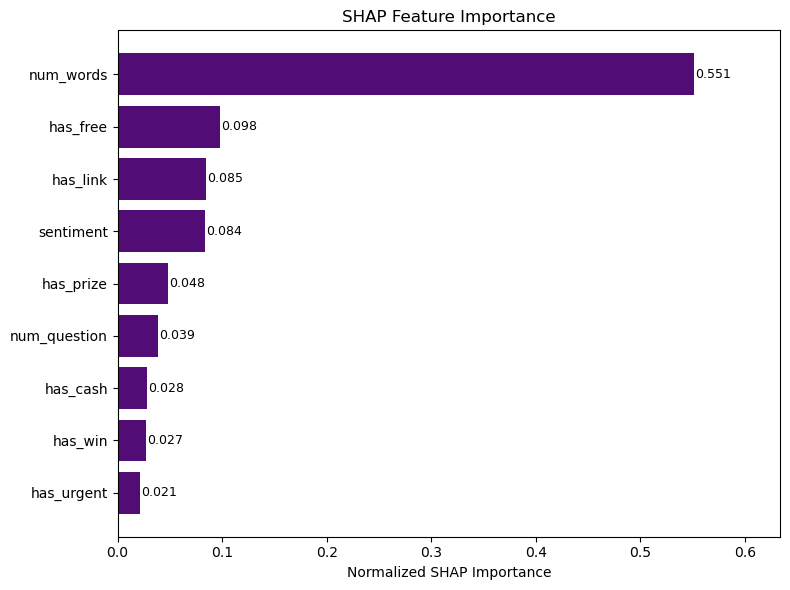

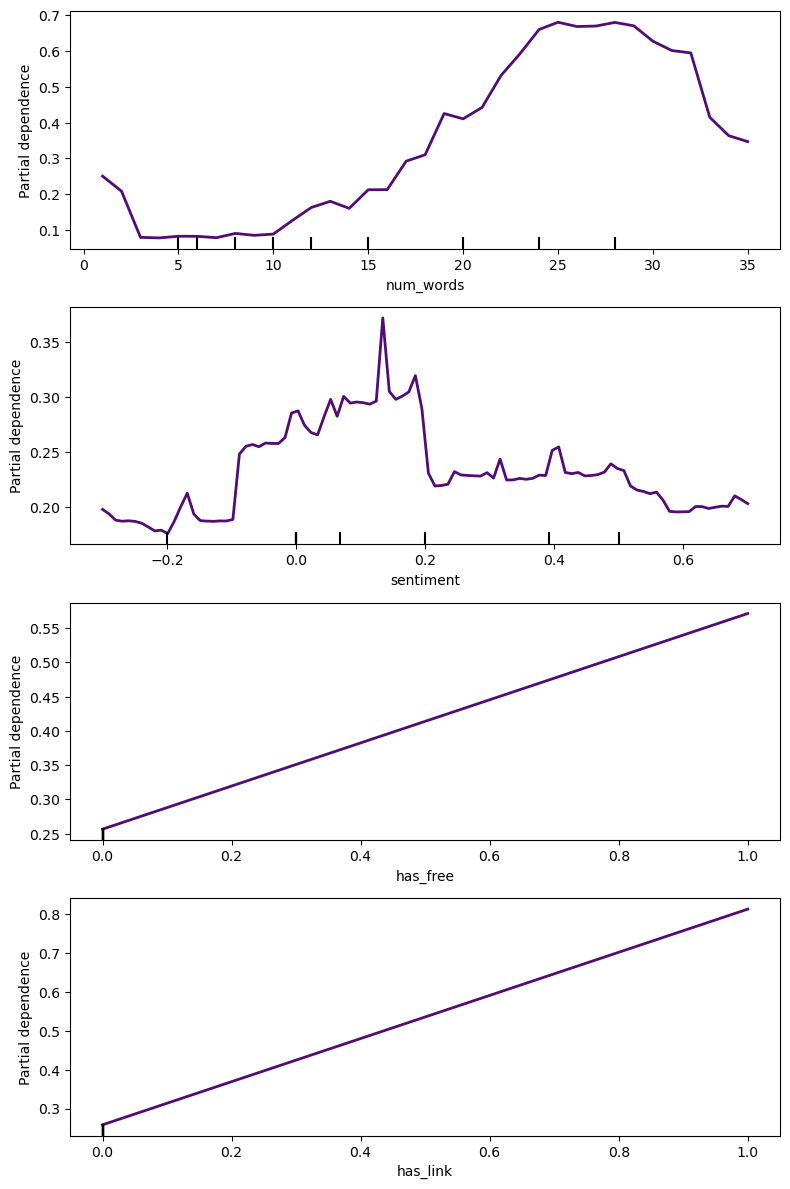

In [27]:
df_filtered = df[df['num_words'] <= 35].copy()

feature_cols = [
    'has_link', 'has_money', 'has_win', 'has_urgent', 'sentiment', 'num_words',
    'num_question', 'has_free', 'has_winner', 'has_cash', 'has_credit', 'has_offer',
    'has_click', 'has_prize', 'has_congratulations', 'has_guarantee'
]

X = df_filtered[feature_cols]
y = df_filtered['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

rf_balanced = RandomForestClassifier(
    n_estimators=498,
    max_depth=14,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_balanced.fit(X_train, y_train)
y_prob = rf_balanced.predict_proba(X_test)[:, 1]
best_threshold = 0.732
y_pred = (y_prob >= best_threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

importances = rf_balanced.feature_importances_

imp_df = pd.DataFrame({
    'feature': rf_balanced.feature_names_in_,
    'importance': importances
})
imp_df['importance_normalized'] = imp_df['importance'] / imp_df['importance'].sum()
imp_df = imp_df.sort_values('importance_normalized', ascending=False)

print("\nNormalized Feature Importances:")
print(imp_df)

X_test_aligned = X_test[rf_balanced.feature_names_in_]
explainer = shap.TreeExplainer(rf_balanced)
shap_all = explainer.shap_values(X_test_aligned)

if isinstance(shap_all, list):
    shap_class1 = shap_all[1]
else:
    shap_class1 = shap_all

if shap_class1.ndim == 3:
    shap_class1 = shap_class1[:, :, 1]

shap_abs = np.abs(shap_class1).mean(axis=0)
shap_norm = shap_abs / shap_abs.sum()

shap_df = pd.DataFrame({
    'feature': rf_balanced.feature_names_in_,
    'shap_importance': shap_norm
})

shap_df_filtered = shap_df[shap_df['shap_importance'] > 0.02] \
    .sort_values('shap_importance', ascending=True)

print(f"\nNumber of features with SHAP importance > 0.02: {len(shap_df_filtered)}")
print(shap_df_filtered)

plt.figure(figsize=(8, 6))
bars = plt.barh(shap_df_filtered['feature'], shap_df_filtered['shap_importance'], color='#510C76')

plt.xlabel('Normalized SHAP Importance')
plt.title('SHAP Feature Importance')

for bar in bars:
    w = bar.get_width()
    plt.text(w + 0.001, bar.get_y() + bar.get_height()/2,
             f'{w:.3f}', va='center', ha='left', fontsize=9)

plt.xlim(0, shap_df_filtered['shap_importance'].max() * 1.15)
plt.tight_layout()
plt.show()

features_to_plot = ['num_words', 'sentiment', 'has_free', 'has_link']

fig, ax = plt.subplots(len(features_to_plot), 1, figsize=(8, 12))

for i, feature in enumerate(features_to_plot):
    PartialDependenceDisplay.from_estimator(
        rf_balanced,
        X_test,
        [feature],
        kind='average',
        target=1,
        ax=ax[i],
        line_kw={"color": "#510C76", "linewidth": 2}
    )

plt.tight_layout()
plt.show()